# Pseudodynamics+ tutorial
1. Preprocessing
2. Training setup
3. Analysing sinlge cell dynamics
4. Continuous density transport

# 1. Preprocessing

## 1.1 Prepare training data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import scanpy as sc
sc.settings.set_figure_params(frameon=False, dpi=30)

# start a python 
# to check if gpu is possible
import torch
torch.cuda.is_available()

KeyboardInterrupt: 

In [6]:
#import python package as pdp (pseudo dynamics plus)
import pseudodynamics as pdp

In [7]:
os.chdir(pdp.main_dir)

In [ ]:
# full data path :
data_path = "/rds/user/bb725/hpc-work/data/tom_pos.h5ad" #make the path as a string because it is a file path
# read in data

# check file exists
if os.path.exists(data_path):
    adata = sc.read_h5ad(data_path)
    
else:
    print("File not found:", data_path)

Mouse in vivo haematopoiesis

In [8]:
#For this we will use a persistant labelling single-cell data from Kucinski & Barile et al, Cell Stem Cell 2024

#Persistent lablelling can induce fluorescence in Hoxb5+ cells and their progeny, so that progeny of stem and progenitor cells can be detected after induction Tom+ expression

#This dataset contains 130700 cells from 9 time points spanning 9 months. At each time point total numbers ot Tom cells were counted in BM

# we can download the expression matrix together with experimental settings

# create a data folder 
if not os.path.exists("data"):
    os.mkdir("data")

#data path
# full data path :
data_path = "/rds/user/bb725/hpc-work/data/tom_pos.h5ad" #make the path as a string because it is a file path

adata_full = sc.read_h5ad(data_path)
adata_full

AnnData object with n_obs × n_vars = 49390 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime', 'leiden_orig', 'logk', 'net_prolif', 'log10SR', 'log_density_at_E3', 'log_density_at_E7', 'log_density_at_E12', 'log_density_at_E12_clip', 'l

Data overviewing and filtering

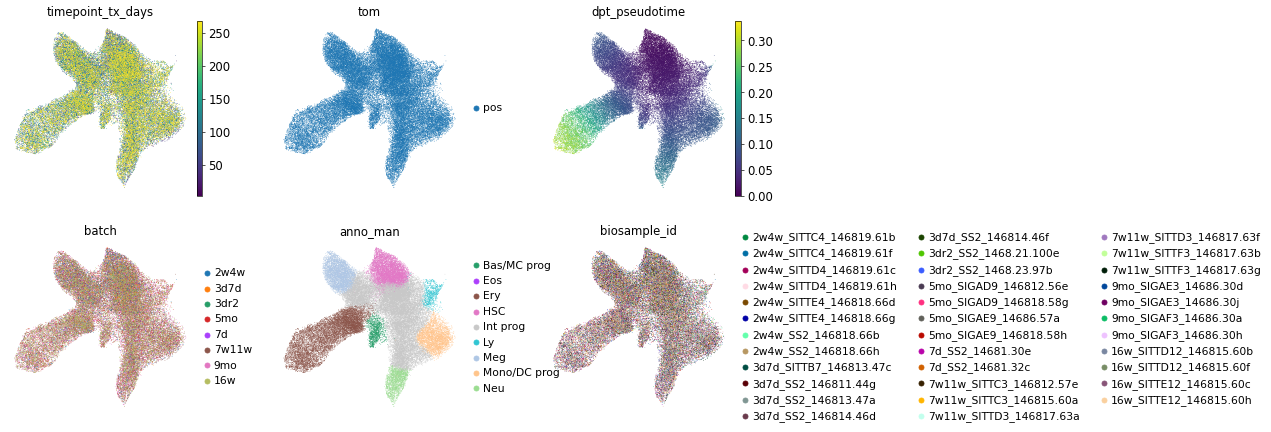

In [9]:
#Pre-processing single-cell landscape is batch-corrected and cell type annotated
sc.pl.umap(adata_full, 
           color=['timepoint_tx_days', 'tom', 'dpt_pseudotime',
                         'batch',  'anno_man', 'biosample_id', ], 
           ncols=3, wspace=0.3)

In [10]:
#Filtering Tom+ cells
#For this dataset newly generated cells are labelled with fluorescence, so we need to filter Tom+ cells and count the number of all Tom+ cells in BM
#At each time point we sequenced and FACS-counted cells from several mice

# select positive cells and saved under data
#Normally code would be this:
# select positive cells and saved under data
#adata = adata_full[adata_full.obs['tom'] == 'pos'].copy()
#adata.write_h5ad('data/tom_pos.h5ad')

#But here using dataset where already all cells are positive for Tom
adata = adata_full
adata.write_h5ad('/rds/user/bb725/hpc-work/data/tom_pos.h5ad') #This line saves the newly filtered cells as a new file to use later

1. Attaching population size measurement

In [11]:
#One of the main innovations of pseudodyanmics+ is the use of population/tissue size measurement that comes from additional experiment, considering that single-cell experiments have issues of limiting capacity and sampling bias
#For datasets without tissue size measurement, can go back to sequenced cell number in sc library - however, the parameter inferred in this manner may fail to refelct the absolute tissue growth and flux transiting between cell state

#Population info is stored as a dictionary and saved under adata.uns['pop'] - pop dictionary contain the follwing keys:
#-'t': the real experiment time point when the cells are counted and sequenced
#-'mean": mean cell number of different experimental repeats for each time point
#-'std': standard derivation of different experimental repeats
#- 'n_lib': number of repeats

adata = sc.read_h5ad('/rds/user/bb725/hpc-work/data/tom_pos.h5ad')
adata

AnnData object with n_obs × n_vars = 49390 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime', 'leiden_orig', 'logk', 'net_prolif', 'log10SR', 'log_density_at_E3', 'log_density_at_E7', 'log_density_at_E12', 'log_density_at_E12_clip', 'l

Load FACS data

In [24]:
adata.uns['pop']['std'] = np.sqrt(adata.uns['pop']['var'])

In [26]:
adata.write_h5ad("data/tom_pos.h5ad")

In [12]:
#Here we load FACs experimental data. BM cells of same mouse are sorted for Tom+ and count total cell number before sending for sequencing

pop_df = pd.read_csv("/rds/user/bb725/hpc-work/data/tom_pos.h5ad")
pop_df.head()

adata
#'pop' exists already in this data, so move on from this section and start from there 2. Rename Timepoint Key

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

2. Rename Timepoint Key

In [13]:
#We use unique obs key timepoint_tx_days to store the timepoint
if 'timepoint_tx_days' not in adata.obs_keys():
    adata.obs['timepoint_tx_days'] = adata.obs['day'].astype(int) # example

/tmp/ipykernel_45820/1618542071.py:2: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if 'timepoint_tx_days' not in adata.obs_keys():


In [14]:
#Check if the timepoint from 'pop' info matches with that in the sequencing data
adata.obs['timepoint_tx_days'].isin(adata.uns['pop']['t']).all()

np.True_

3. Compute diffusion map (DM)

/tmp/ipykernel_45820/3922053771.py:7: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if 'X_diffmap' not in adata.obsm_keys():


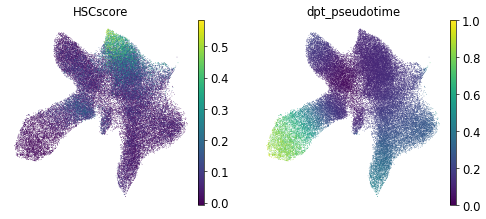

In [15]:
#Example dataset has pre-computed diffusion maps
#Here we for demonstration we show two popular methods of getting DN coordinates and pseudotine
#- scanpy difussion map and dpt_pseudotime
#- palantir diffusion map and palantir pseudotime
adata

if 'X_diffmap' not in adata.obsm_keys():
    # use batch corrected cell representation like Harmonied PC or SCVI latent
    sc.pp.neighbors(adata, n_pcs=30, use_rep='X_pca_harmony') 
    sc.tl.diffmap(adata, n_comps=10)

adata.uns['iroot']= np.argmin(adata.obs['HSCscore'].values)
sc.tl.dpt(adata)

sc.pl.umap(adata, color=['HSCscore', 'dpt_pseudotime'])



In [16]:
# next we scaled the diffusion map to 0-1.
DM = adata.obsm['X_diffmap']
DM_min = DM.min(axis=0,keepdims=True)
DM_range = DM.max(axis=0,keepdims=True) - DM_min
DM_scaled = (DM - DM_min)/DM_range

In [17]:
#Use palantir to compute DM
import palantir
dm_res = palantir.utils.run_diffusion_maps(adata, pca_key='X_pca_harmony')
ms_data = palantir.utils.determine_multiscale_space(adata)

print(f"shape of palantir DM : {adata.obsm['DM_EigenVectors'].shape} and scaled DM : {adata.obsm['DM_EigenVectors_multiscaled'].shape} ")

shape of palantir DM : (49390, 10) and scaled DM : (49390, 6) 


4. Sample local cell state changes in diffusion map

In [18]:
#Pseudodynamics+ can make use of local cell state changes in diffusion maps to assits learning velocity.
#This state chnage is defined as a function (check function in tutorial). Here we provide two ways of sampleing this local state transition:
#1. by default we rely on KNN and pseudotie wij denoting connectivities in KNN
#2. alternatively, when a transition matrix is provided (ex cellrank) - the wij denote the probabiblity of transitioning from i to j

delta_DM , neighbors = pdp.tl.sample_deltax(adata, xkey='DM_scaled', pseudotimekey='dpt_pseudotime', repeat=10)
delta_DM_ay = np.stack(delta_DM)

print(delta_DM_ay.shape)
adata.obsm['Delta_DM'] = delta_DM_ay.mean(axis=-1) # use the averaged ∆DM

/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/reader_funs.py:563: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  elif xkey in adata.obsm_keys():
100%|██████████| 49390/49390 [01:30<00:00, 545.64it/s]


(49390, 10, 30)


5. Train test split

In [19]:
def train_test_split_adata(adata,  leaveout=None, val_size=0.1, test_size=0.1, timepoint_key='timepoint_tx_days'):

    obs = adata.obs
    val_test_cbs = obs.query(f"`{timepoint_key}` not in @leaveout").sample(frac=0.2).index
    test_cb = np.random.choice(val_test_cbs, size=len(val_test_cbs)//2,replace=False)

    split_mapper = {cb:'test' for cb in test_cb}
    val_cbs = {cb:'val' for cb in val_test_cbs if cb not in test_cb}
    train_cbs = {cb:'train' for cb in adata.obs_names if cb not in val_test_cbs}

    split_mapper.update(val_cbs)
    split_mapper.update(train_cbs)

    return adata.obs.index.map(split_mapper)

adata.obs['split'] = train_test_split_adata(adata, leaveout=[3])

In [20]:
adata.write_h5ad("data/tom_pos.h5ad")

#Next estimate single-cell density at observed time point
#Set up training configuration

## 1.2 Estimate single-cell density at observed time point

In [ ]:
#Pseudodyanmics+ leverage a concpet called Physics-Informed Neural Networks (PINN) which can solve the forward and inverse problem of PDE
#We applies the continuous PINN which requires:

#- the model correctly predict density at observed time points and data points
#- the model follows the PDE (physics formular) anywhere (collocation point : unobserved cell state) and anytime (collocation time : unobserved time point)

#In here we will go thorugh several density estimator that could serve as the label for solving PINN
#1. Gaussian
#2. Mellon (!!)
#3. HBE

In [21]:
#Remember that density estimation in high-dimensional space is not trivial. None of the methods above capture true density as the true manifold of single-cell data is never known
%load_ext autoreload
%autoreload 2

import os, sys
if sys.platform.startswith("darwin"):
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
sc.settings.set_figure_params(frameon=False, dpi=30)

import pseudodynamics as pdp
os.chdir(pdp.main_dir)
print("workding directory changed to:", pdp.main_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
workding directory changed to: /rds/user/bb725/hpc-work/pseudodynamics_plus


In [22]:
adata = sc.read_h5ad('data/tom_pos.h5ad')
adata

AnnData object with n_obs × n_vars = 49390 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime', 'leiden_orig', 'logk', 'net_prolif', 'log10SR', 'log_density_at_E3', 'log_density_at_E7', 'log_density_at_E12', 'log_density_at_E12_clip', 'l

1. Gaussian KDE

In [23]:
#This is the conventional density estimation method. 
#In the manuscript, we benchmarked several methods, and this traditional Gaussian KDE works stably and can reproduce the shift in dense cell states along the differrentaition trajectory.

#Gaussian KDE is used y default when running the training script main_train.py
#Two args can be passed to adjust
#1. --bw : the kernel size
#2. --knn_volume : scale density by a cells KNN volume

# list cell by time
obs = adata.obs
CB_ay = [obs.query('`timepoint_tx_days` == @t').index for t in adata.uns['pop']['t']]


# cell state coordiate

cellstate_key = "DM_scaled"
n_dim = 5

# scale to 0-1
DM_x = adata.obsm[cellstate_key][:,:n_dim]

DM_min = DM_x.min(axis=0, keepdims=True)
DM_x_range = (DM_x.max(axis=0, keepdims=True) - DM_min)

# update 
norm_DMx = (DM_x - DM_min) / DM_x_range
adata.obsm[cellstate_key] = norm_DMx

# calculate
DM_normed = [adata[cbs].obsm[cellstate_key] for cbs in CB_ay]
print(DM_normed[0].shape)

(394, 5)


In [24]:
# bandwidth
bw = None
bw = 0.5

prediction of shape (9, 49390)


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/plotting_fns/density_plot.py:65: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  timepoint_key = 'timepoint_tx_days' if 'timepoint_tx_days' in anndata.obs_keys() else 'timepoint'


(<Figure size 729x60 with 18 Axes>,
 array([<Axes: title={'center': 'Day3_KDE u\nmin:0.e+00\nmax:3.86e+03'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day7_KDE u\nmin:0.e+00\nmax:2.16e+05'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day12_KDE u\nmin:0.e+00\nmax:4.74e+04'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day27_KDE u\nmin:0.e+00\nmax:1.00e+05'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day49_KDE u\nmin:0.e+00\nmax:4.51e+04'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day76_KDE u\nmin:0.e+00\nmax:1.05e+05'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day112_KDE u\nmin:2.10e-139\nmax:2.73e+04'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day161_KDE u\nmin:3.63e-81\nmax:3.76e+04'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day269_KDE u\nmin:2.47e-198\nmax:4.08e+04'}, xlabel='UMAP1', ylabel='U

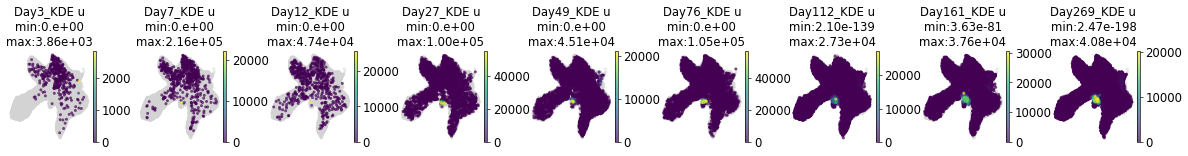

In [25]:
from scipy.stats import gaussian_kde

kde_kernel = []
kde_u = []

for dm in DM_normed:
    # print(dm.shape)
    # kde_fn = gaussian_kde(dm.T, bw_method='silverman')       # take in [n_dim, n_sample]
    kde = gaussian_kde(dm.T, bw_method=bw)
    kde_kernel.append(kde)
    u_t = kde(DM_x.T)  # full DM
    kde_u.append(u_t)

kde_u = np.stack(kde_u)

pdp.pl.params_in_umap(adata, kde_u, param='KDE u')

2. Mellon

estimating density for time  3
[2026-02-02 10:51:00,099] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (394) >= n_samples (394) and rank = 1.0.
[2026-02-02 10:51:00,100] [INFO    ] Computing nearest neighbor distances.
[2026-02-02 10:51:03,662] [INFO    ] Using embedding dimensionality d=10. Use d_method="fractal" to enable effective density normalization.
[2026-02-02 10:51:04,577] [INFO    ] Using covariance function Matern52(ls=0.009263400919735432).
[2026-02-02 10:51:04,578] [INFO    ] Computing Lp.
[2026-02-02 10:51:06,503] [INFO    ] Using rank 394 covariance representation.
[2026-02-02 10:51:07,635] [INFO    ] Running inference using L-BFGS-B.
[2026-02-02 10:51:09,054] [INFO    ] Computing predictive function.
estimating density for time  7
[2026-02-02 10:51:10,024] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (633) >= n_samples (633) and rank = 1.0.
[2026-02-02 10:51:10,024] [INFO    ] Computing nearest neighbor distances.
[2026-02-02 10:51:10,

/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/plotting_fns/density_plot.py:65: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  timepoint_key = 'timepoint_tx_days' if 'timepoint_tx_days' in anndata.obs_keys() else 'timepoint'


0.8430185795500742
[2026-02-02 10:53:09,654] [INFO    ] Explicitly provided d=2, setting d_method to 'manual'.
[2026-02-02 10:53:09,694] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (49,390) and rank = 1.0.
[2026-02-02 10:53:09,695] [INFO    ] Computing nearest neighbor distances within time points.
[2026-02-02 10:53:17,425] [INFO    ] Using covariance function (Matern52(active_dims=slice(None, -1, None), ls=0.004170363110025103) * Matern52(active_dims=-1, ls=0.8430185795500742)).
[2026-02-02 10:53:17,605] [INFO    ] Computing 5,000 landmarks with k-means clustering (random_state=42).
[2026-02-02 10:53:36,828] [INFO    ] Using rank 5,000 covariance representation.
[2026-02-02 10:54:33,978] [INFO    ] Running inference using L-BFGS-B.
[2026-02-02 10:54:49,427] [INFO    ] Computing predictive function.
estimating density for time  1.0986122886681098
estimating density for time  1.9459101490553132
estimating density for time  2.4849066497880004
estimating

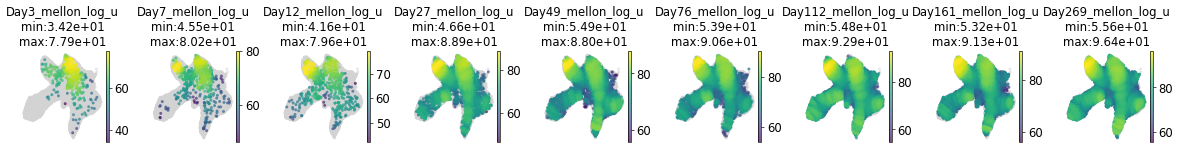

In [26]:
#Mellon uses a gaussian process to model cell density (https://www.nature.com/articles/s41592-024-02302-w)
#Our package includes Mellon by:
## pdp.tl.compute_mellon_u
## pdp.tl.compute_mellon_timesense_u

#Pseudodynamics+ integrate mellon for solcing sc population dynamics. Use a different training script:
## dudt_train_mellon.py

# For time sensitive model as an example

cellstate_key = 'DM_EigenVectors'
timepoint_key = 'timepoint_tx_days'    # 

log_u, mellon_fns = pdp.tl.compute_mellon_u(adata, 
                            cellstate_key = cellstate_key,
                            timepoint_key = timepoint_key, 
                            n_dimension=None)

# like KDE, each time point has its own density function 
print("# of estimators : ", len(mellon_fns))

# a big difference is that Mellon returns log density
pdp.pl.params_in_umap(adata, log_u, param='mellon_log_u')

#To use a time-sensitive mellon model, we need to specify ls_time parameter which prefers shorr and identical interval timepoints
#For long-term in vivo data, we use log-time for demonstration (which is a strong assumption).
adata.obs['log_timepoint'] = adata.obs['timepoint_tx_days'].apply(lambda x: np.log(x))

# For time sensitive model as an example

cellstate_key = 'DM_EigenVectors'
timepoint_key = 'log_timepoint'    

log_u, density_predictor = pdp.tl.compute_mellon_timesense_u(adata, 
                            cellstate_key = cellstate_key,
                            timepoint_key = timepoint_key, 
                            n_dimension=None)

# this time-dependent predictor allows us to predict density at any time point

t = np.log(46) # an 
X = adata.obsm[cellstate_key] 
density_d46 = density_predictor(X, t)

#We can save this precomputed predictor for later use during training
density_predictor.to_json(f"data/tom_pos_mellon_timecontinuous_predictor.json")

## 1.3. Efficient kernel density estimator for atlas level data

In [27]:
import sys
sys.path.append('/home/bb725/rds/hpc-work/efficient_kde') # add a new directory to the system path so that python can find the package

In [28]:
from kde import FastLaplacianKDE, kde

True KDE: 0.001
Estimated KDE: 0.001


In [29]:
#Traditional Gaussian KDE scales are not suitable to sample size. For atlas with millions of cells, we can use a hash-based estimator for sample-efficiency

#The package efficient_kde provide several estimators for acceleration

# Hyperparameter for HBE
bandwidth = 1
L = 90

In [30]:
# list cell by time
obs = adata.obs
CB_ay = [obs.query('`timepoint_tx_days` == @t').index for t in adata.uns['pop']['t']]


# cell state coordiate
# scale to 0-1
DM_x = adata.obsm['DM_EigenVectors_multiscaled']

DM_min = DM_x.min(axis=0, keepdims=True)
DM_x_range = (DM_x.max(axis=0, keepdims=True) - DM_min)

# update 
norm_DMx = (DM_x - DM_min) / DM_x_range
adata.obsm['DM_EigenVectors_multiscaled'] = norm_DMx

# calculate
DM_normed = [adata[cbs].obsm['DM_EigenVectors_multiscaled'] for cbs in CB_ay]

In [33]:
hbe

0
1
2
3
4
5
6
7
8
prediction of shape (9, 49390)


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/plotting_fns/density_plot.py:65: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  timepoint_key = 'timepoint_tx_days' if 'timepoint_tx_days' in anndata.obs_keys() else 'timepoint'


(<Figure size 729x60 with 18 Axes>,
 array([<Axes: title={'center': 'Day3_HBE u\nmin:0.e+00\nmax:0.e+00'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day7_HBE u\nmin:0.e+00\nmax:0.e+00'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day12_HBE u\nmin:0.e+00\nmax:0.e+00'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day27_HBE u\nmin:0.e+00\nmax:0.e+00'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day49_HBE u\nmin:0.e+00\nmax:0.e+00'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day76_HBE u\nmin:0.e+00\nmax:0.e+00'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day112_HBE u\nmin:0.e+00\nmax:2.88e-08'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day161_HBE u\nmin:0.e+00\nmax:0.e+00'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day269_HBE u\nmin:0.e+00\nmax:2.95e-10'}, xlabel='UMAP1', ylabel='UMAP2'>],
       dtype=

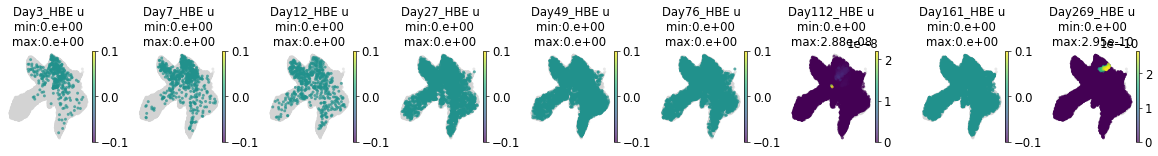

In [50]:
hbe_kernel = []
hbe_u = []

for i, dm in enumerate(DM_normed): # now the code analyses timepoint one by one instead of all at once
    # print(dm.shape)
    # kde_fn = gaussian_kde(dm.T, bw_method='silverman')       # take in [n_dim, n_sample]
    print(i)
    hbe = FastLaplacianKDE(dm, bandwidth=0.05, L=30)
    hbe_kernel.append(hbe.kde)
    u_t =[ hbe.kde(dm_i) for dm_i in DM_x ] # now the code analyses cells one by one at each time point
    hbe_u.append(u_t)

hbe_u = np.stack(hbe_u)

pdp.pl.params_in_umap(adata, hbe_u, param='HBE u')

# 2. Set up training config

In [2]:
#pseudodynamics+ provides two ways of passing arguments when runing with a script.
#One is to pass -a or --arg. The other one saves different args a config file to set up the training for tracing differernt models and better reproducibility.

#Here we will
#1. Go through different arguments
#2. Create config json file
#3. See how to generate an ExperimentConfig object using a config file

%load_ext autoreload
%autoreload 2

import os, sys
# if sys.platform.startswith("darwin"):
#     os.environ['KMP_DUPLICATE_LIB_OK']='True'

import json
import pseudodynamics as pdp

os.chdir(pdp.main_dir)

## 1. Basic args

In [3]:
basic_config =  {
        "config": None,
        "dataset": "tom_pos",                  # the dataset prefix of the h5ad file, i.e. "data/tom_pos.h5ad"
        "log_name": "tom_pos_fulltime",  # the name of the logging directory ( logs/`log_name` )
        "progress_bar": True
}

In [4]:
model_config = {
    
    # Model choice
    "model" : "pde_params",     # pseudodynamics model , `log_pde_params` as another option
    "time_sensitive": True,      # True: parameters time and state dependent. False : parameters time independent
    
    # Neural network
    "n_dimension": 10,           # input size and the dimension for density estimation
    "channels": "64,64",         # the hidden layer size, e.g. "64,64" means 4 layer density network [input, 64, 64, output]

    "lr": 0.0003,                # learning rate
    "schedule_lr": "CyclicLR",   # learning rate scheduler

    # dynamics equation precision
    "tol": 0.0001,               # tolerance for NeuralODE integral , atol = tol, rtol = tol
    "time_scale_factor" : 1,     # factor scaling the time of integral for NeuralODE, smaller factor -> longer integral
    
    
    "pretrained": None,      # resume 
    "gpu_devices": 0,        # which GPU to use, set to None for CPU training
    

    # Loss term related weights
    "weight_intensity": None,      # the weight to emphasize the high density cell, > 1 for weighting, <1 for unweighting
    "deltax_weight": 0.01,         # the weight used to inform v with local state transition, which is the similarity of deltax and v
    "R_weight": 1,                 # the weight to balance PDE residue loss and the data-related loss
    "growth_weight": None,         # the weight to regularize the contribution of growth to overall density gain, greater means harder boundary
    "D_penalty" :  1,              # the level of restricting Diffusion

}

In [16]:
#Important arg
dataset_config =  {

        "cellstate_key": "DM_scaled",   # obsm key used as cell state
        "deltax_key": "Delta_DM",                    # obsm key used for local cell state changes
        "timepoint_idx": [                              
            0,
            1,
            2,
            3,
            4,
            6,
            8
        ],                                          # the timepoints to use , numeric index


        "knn_volume": "False",
        "batch_size": 50,
        "bw": None,
    
        "norm_time": False,
    }

In [17]:
raw_args = {}
raw_args.update(basic_config)
raw_args.update(model_config)
raw_args.update(dataset_config)

configs = {"raw_args": raw_args}

In [18]:
with open('logs/testing_config.json', 'w') as f:
    json.dump(configs, f, indent=4)

## 2. Instanize a config object

In [11]:
test_config = pdp.ExperimentConfig(config='logs/testing_config.json')


In [12]:
print("\nDoes 'logs/testing.json' exist?")
print(os.path.exists("logs/testing.json"))



Does 'logs/testing.json' exist?
False


In [13]:
import os

filename = "testing.json"

print("Current working directory:")
print(os.getcwd())

print(f"\nDoes '{filename}' exist here?")
print(os.path.exists(filename))


Current working directory:
/rds/user/bb725/hpc-work/pseudodynamics_plus

Does 'testing.json' exist here?
False


In [14]:
test_config._get_model_config()

{'model_class': 'pde_params',
 'channels': '64,64',
 'activation_fn': None,
 'ode_tol': 0.0001,
 'growth_weight': None,
 'R_weight': 1,
 'D_penalty': 1,
 'deltax_weight': 0.01,
 'weight_intensity': None,
 'time_scale_factor': 1,
 'time_sensitive': True,
 'v_channels': None,
 'g_channels': None,
 'D_channels': None}

In [19]:
adata

NameError: name 'adata' is not defined

## 3. Training

In [ ]:
#We suggest using the script to train the model. Under the prjoject main directory, run the following command:

#python main_train.py --config logs/testing_config.json -G None #cpu
#python main_train.py --config logs/testing_config.json -G 0 #gpu

#An experimental record will be automatically generated under the log_name directory. 
#For example, the above command will generate a record under the logs/tom_pos_fulltime/pde_params_tsense/V0-config.json. 
#The record file can be used to resume the model and the dataset.

# load record json
v0_config = pdp.ExperimentConfig(config='logs/tom_pos_fulltime/pde_params_tsense/V0_config.json')


# check updated model config
v0_config.model_config

# we can locate the checkpoint by: 
v0_config.find_lastest_ckpt()


SyntaxError: invalid syntax (730933287.py, line 2)

# 3. Evaluate behaviour parameters

In [1]:
#Now we will use the trained model to evaluate dynamics behaviour for g, v, and D fo each cell
#The combination of these three parameters shapes the dynamic behaviour of each cell

#For this to start you need to load:
#1. load trained model
#2. load data
#3. evaluate parameters
#4. perform short-temr simulation

%load_ext autoreload
%autoreload 2

import os, sys
if sys.platform.startswith("darwin"):
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
sc.settings.set_figure_params(frameon=False, dpi=30)

import pseudodynamics as pdp
os.chdir(pdp.main_dir)
print("workding directory changed to:", pdp.main_dir)

workding directory changed to: /rds/user/bb725/hpc-work/pseudodynamics_plus


## 1. Experimental config

In [6]:
tompos_config_path = "logs/tom_pos-DM_scaled_n[0, 1, 2, 3, 4, 6, 8]/pde_params_tsense/V4_config.json"
tompos_config = pdp.ExperimentConfig(config=tompos_config_path)

In [7]:
tompos_config.find_lastest_ckpt()

'/rds/user/bb725/hpc-work/pseudodynamics_plus/logs/tom_pos-DM_scaled_n[0, 1, 2, 3, 4, 6, 8]/pde_params_tsense/lightning_logs/version_4/checkpoints/epoch=95-total_loss=1.33532071.ckpt'

In [8]:
from pseudodynamics import models
pde_model = models.pde_params.load_from_checkpoint(
                    checkpoint_path = tompos_config.find_lastest_ckpt(), 
                    map_location='cpu')

In [ ]:
#Check if it learns time-dependent parameters
pde_model.time_sensitive

## 2. Resume dataloader

In [9]:
#We can retrieve which single cell dataset to use from basic experimental config
# load config
data_name = tompos_config.experiment_config['dataset']
print(data_name)

# load adata
adata = sc.read_h5ad(f"data/{data_name}.h5ad")
adata

tom_pos


AnnData object with n_obs × n_vars = 49390 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime', 'leiden_orig', 'logk', 'net_prolif', 'log10SR', 'log_density_at_E3', 'log_density_at_E7', 'log_density_at_E12', 'log_density_at_E12_clip', 'l

In [ ]:
#We can resume a DataSet object with the single-cell data and the settings
#By default we use the TwoTiempoint_AnnDS which trains the model for connecting two consecutive time points.
# # To resume the original dataloader without masked-out time point
from pseudodynamics import reader
DS_sub = pdp.reader.TwoTimpepoint_AnnDS(AnnData=adata, split = 'train',
                                **tompos_config.dataset_config
                              )
                     

/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/_base_Dataset.py:35: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  assert cellstate_key in AnnData.obsm_keys(),  f'cellstate key `{cellstate_key}` not found in adata'
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/_base_Dataset.py:36: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  assert timepoint_key in AnnData.obs_keys(),  f'timepoint key `{timepoint_key}` not found in adata'
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/reader.py:78: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  elif deltax_ke


Dataset : Computing density :
	 `density_funs` not specified, default estimator gaussian kde


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/reader.py:320: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if 'split' not in self.adata.obs_keys():
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/_base_Dataset.py:35: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  assert cellstate_key in AnnData.obsm_keys(),  f'cellstate key `{cellstate_key}` not found in adata'
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/_base_Dataset.py:36: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  assert timepoint_key in AnnData.obs_keys(),  f'timepoint key `{timepo


Dataset : Computing density :
	 `density_funs` not specified, default estimator gaussian kde
Dataset : all cells are used


In [ ]:
# To resume the full dataset with all time points
ds_config = tompos_config.dataset_config.copy()
ds_config['timepoint_idx'] = None

DS_full = reader.TwoTimpepoint_AnnDS(AnnData=adata, split = None,
                            **ds_config
                        )  

## 3. Predict dynamic parameters for single cell

In [11]:
#Pseudodynamics+ follows an advected-diffusion equation to model density changes
#For time-dependent parameters growth rate (g), differentiation rate (v), Diffusion (D) can change by t veen for same cell state s

# here we have a one-line code to predict the parameters for all cell and time point
g_pred_ay, v_pred_ay, D_pred_ay = pde_model.predict_param(DS_full)


print(f'the number of cell : {adata.shape[0]}')
print(f'the number of time points : {adata.uns["pop"]["t"].shape[0]}' )
print('the shape of growth rate :\t\t', g_pred_ay.shape)
print('the shape of differentaition rate :\t', v_pred_ay.shape)
print('the shape of diffusion :\t\t', D_pred_ay.shape)

the number of cell : 49390
the number of time points : 9
the shape of growth rate :		 (9, 49390)
the shape of differentaition rate :	 (9, 49390, 10)
the shape of diffusion :		 (9, 49390)


prediction of shape (9, 49390)


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/plotting_fns/density_plot.py:65: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  timepoint_key = 'timepoint_tx_days' if 'timepoint_tx_days' in anndata.obs_keys() else 'timepoint'


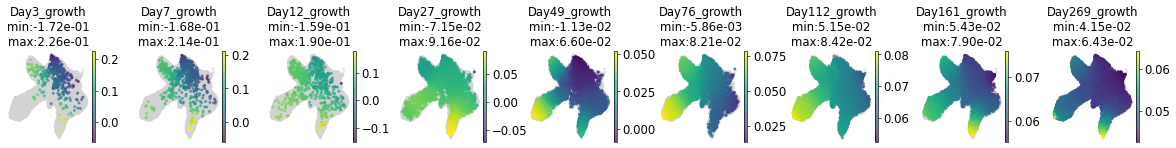

In [12]:
# we can visualize the growth rate by 
fig, ax = pdp.pl.params_in_umap(adata, prediction=g_pred_ay, param = 'growth')

prediction of shape (9, 49390)


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/plotting_fns/density_plot.py:65: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  timepoint_key = 'timepoint_tx_days' if 'timepoint_tx_days' in anndata.obs_keys() else 'timepoint'


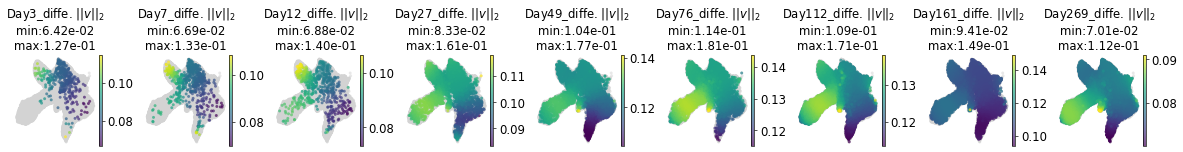

In [13]:
#differentiation rate is a high-dimensional vector which denotes immediate movement in every dimension of the diffusion map space.
#To visualize it, we calculate vectorial sum which represents the overall distace of movement in a short time interval
v_norm = np.sqrt(np.sum(v_pred_ay**2, axis=-1))
fig, ax = pdp.pl.params_in_umap(adata, prediction=v_norm, param = r'diffe. $||v||_2$')

In [ ]:
#For computational simplicity pseudodynamics+ assumes an isogenic diffusion paarmeter which means D s the same for all dimensions
# Parameter D also buffers the under-fit density changes during training which makes it difficult to interpret

## 4. Predicting parameters for abritrary time point

In [14]:
#pseudodynamics+ learns behaviour netwrok corresponding to each parameter. This network allows us to impute the parametrs for any time point
import torch
# the cell state matrix
s = torch.from_numpy(DS_full.cellstate).float()
print(s.shape, s.dtype)

torch.Size([49390, 10]) torch.float32


In [15]:
# for example we impute day 5 and day 18
g_impute = []

with torch.no_grad():
    
    for t in [5,18,36]:
        t_input = torch.Tensor([t]).broadcast_to((s.shape[0],1))     # make them a tenso
        g_t = pde_model.g(s,t_input).cpu().numpy()
        g_impute.append(g_t)

    g_impute = np.stack(g_impute)
    print(g_impute.shape)

(3, 49390)


prediction of shape (3, 49390)


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/plotting_fns/density_plot.py:65: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  timepoint_key = 'timepoint_tx_days' if 'timepoint_tx_days' in anndata.obs_keys() else 'timepoint'


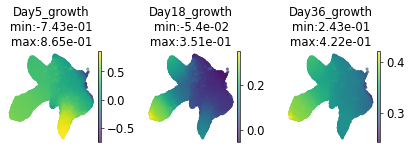

In [16]:
fig, ax = pdp.pl.params_in_umap(adata, prediction=g_impute, param = 'growth', timepoints=[5, 18, 36], cell_of_t=False)

5. Continuous parameters

In [17]:
#Next we inspect the evolution of parametrs in a time-continuous way
#For easier visualisation, we group parameters by cell types
# 
grouped_params = pdp.tl.continuous_params(pde_model, DS_full, 
                                        param='g',
                                        groupby_key='fine_anno',  # group parameters by refined cell type, set to None if you want to keep single cell resolution
                                        n_interval=10,      # the resolution, the number of time intervals between two observed time points 
                                        device='cpu') 

grouped_param = pd.concat(grouped_params, axis=0)
grouped_param['g'] = grouped_param['g'].values 
grouped_param = grouped_param.query("`ct_of_day` > 10")   # only include cell type with more than 10 cells at the time
grouped_param['variable'] = grouped_param.variable.astype(float)

0it [00:00, ?it/s]

from 1.0 to 2.3333333333333335


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_count_dict = obs_t.query(f"`{DataSet.timepoint_key}` == @real_time").groupby([groupby_key]).agg({"str_col":'count'}).to_dict()['str_col']
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params = obs_t[agg_col+[groupby_key]].groupby(groupby_key).agg(agg_fun)


from 2.3333333333333335 to 4.0


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_count_dict = obs_t.query(f"`{DataSet.timepoint_key}` == @real_time").groupby([groupby_key]).agg({"str_col":'count'}).to_dict()['str_col']
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params = obs_t[agg_col+[groupby_key]].groupby(groupby_key).agg(agg_fun)
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:167: FutureWarning: The default of obser

from 4.0 to 9.0


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params = obs_t[agg_col+[groupby_key]].groupby(groupby_key).agg(agg_fun)
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_count_dict = obs_t.query(f"`{DataSet.timepoint_key}` == @real_time").groupby([groupby_key]).agg({"str_col":'count'}).to_dict()['str_col']


from 9.0 to 16.333333333333332


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params = obs_t[agg_col+[groupby_key]].groupby(groupby_key).agg(agg_fun)
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_count_dict = obs_t.query(f"`{DataSet.timepoint_key}` == @real_time").groupby([groupby_key]).agg({"str_col":'count'}).to_dict()['str_col']


from 16.333333333333332 to 25.333333333333332


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params = obs_t[agg_col+[groupby_key]].groupby(groupby_key).agg(agg_fun)
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_count_dict = obs_t.query(f"`{DataSet.timepoint_key}` == @real_time").groupby([groupby_key]).agg({"str_col":'count'}).to_dict()['str_col']


from 25.333333333333332 to 37.333333333333336


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params = obs_t[agg_col+[groupby_key]].groupby(groupby_key).agg(agg_fun)
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_count_dict = obs_t.query(f"`{DataSet.timepoint_key}` == @real_time").groupby([groupby_key]).agg({"str_col":'count'}).to_dict()['str_col']


from 37.333333333333336 to 53.666666666666664


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params = obs_t[agg_col+[groupby_key]].groupby(groupby_key).agg(agg_fun)
/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_count_dict = obs_t.query(f"`{DataSet.timepoint_key}` == @real_time").groupby([groupby_key]).agg({"str_col":'count'}).to_dict()['str_col']


from 53.666666666666664 to 89.66666666666667


/rds/user/bb725/hpc-work/pseudodynamics_plus/src/pseudodynamics/functions/eval_funs.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params = obs_t[agg_col+[groupby_key]].groupby(groupby_key).agg(agg_fun)
